In [1]:
# This notebook is typically run on Google Colab, where it is necessary to mount the directory in GoogleDrive from which we work
# if it is not being run on colab then we skip past these lines.

try:
    from google.colab import drive
    drive.mount('/content/Drive')
    import sys
    path = '/content/Drive/Shareddrives/Thesis/Trading'
    sys.path.append(path)  # Updating our path to import drom drive
    import os
    os.chdir(path)
    
except:
    print("Not on Google Collab")
    path = ""
    

Mounted at /content/Drive


In [2]:
# Importing Relevant Modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (10, 4)})
import importlib
import xgboost
import lightgbm

# Sklearn Imports
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score

import ThesisUtils as tu # ThesisUtils is the python script found in this folder which contains various classes and funtions I wrote and use throughout this project
importlib.reload(tu)
from ThesisUtils import GroupTimeSeriesSplit
from ThesisUtils import PurgedGroupTimeSeriesSplit

### Importing Datasets

In [10]:
# Importing the dataset which was created in the "EDA.ipynb" file

data = pd.read_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/data_cleaned.csv")

In [11]:
# Transforming the data 
# The make_log_returns_series turns the dataset into a supervised one that can be fed into machine learning models
# The X variable is 7 lags (lag1, lag2, ... , lag7) of price return and 1 lag of volume(lag1)
# y is lag0 of price return 
# The truncate parameter applies a tanh transform to truncate the values between -0.03 and 0.03. This helps reduce noise and outliers which machine learning models can be very sensitive to

X,y = tu.make_log_returns_series(data, num_lags = 7, lagged_col = "Close", truncate = 0.03, x_as_series=False)
X.shape

(42974, 8)

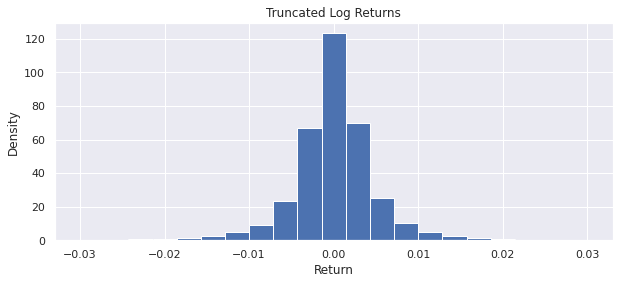

In [15]:
# Plotting a histogram of returns

plt.hist(y, bins=21,density = True)
plt.title("Truncated Log Returns")
plt.xlabel("Return")
plt.ylabel("Density")
plt.show()
#plt.savefig("/content/Drive/Shareddrives/Thesis/Trading/eda/FTSE100TruncatedReturns.jpg")

Text(0, 0.5, 'Return')

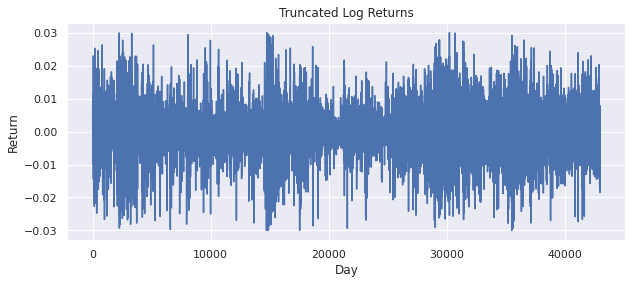

In [17]:

# Plotting the log returns as a line chart

plt.plot(y)
plt.title("Truncated Log Returns")
plt.xlabel("Day")
plt.ylabel("Return")
plt.show()

#plt.savefig("/content/Drive/Shareddrives/Thesis/Trading/eda/FTSE100TruncatedReturnsSeries.jpg")

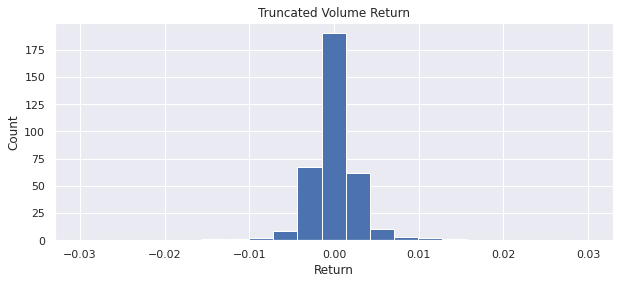

In [19]:
plt.hist(X[:,-1], bins=21,density = True)
plt.title("Truncated Volume Return")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()
#plt.savefig("/content/Drive/Shareddrives/Thesis/Trading/eda/FTSE100TruncatedVolumeReturns.jpg")

### Creating Stacked Dataset

In [21]:
importlib.reload(tu)
NUM_LAGS = 7 #sets the number of lagged values to include in the analysis
X,y = tu.make_log_returns_series(data, num_lags = NUM_LAGS, lagged_col = "Close", truncate = 0.03, x_as_series=False) # Makes the lagged dataset required 

#X = X[:3000,:]
#y = y[:3000].ravel()

# Here we define a class for multiple sub learners. 

mlp = MLPRegressor(random_state=0) # Multi-Layered Perceptron
xgbr = xgboost.XGBRegressor(objective ='reg:squarederror') # XGBoost Regressor
ridge = Ridge() # Ridge Regression Class
lgbmr = lightgbm.LGBMRegressor() # Light Gradient Boosted Machine class

# each  _grid is the search space for each model. 
# Expanding this will help to better performing models in general, but increases running time


mlp_grid = {
    "model__hidden_layer_sizes" : [[32,32,32,32]],
    "model__alpha":[0.001],
    "model__learning_rate_init":[0.001],
    "model__max_iter":[1000],
    "model__early_stopping":[True]
}

xgbr_grid = {
    'model__learning_rate':[0.2,0.3,0.4],
    'model__n_estimators':[100,200],
    'model__max_depth':[-1,5,10]

}

ridge_grid = {
    'model__alpha':[10,50,100],
}

lgbmr_grid = {
    'model__learning_rate':[0.05,0.1,0.2],
    'model__n_estimators':[100,200],
    'model__max_depth':[-1,5,10]
}

# Here we decide which models to factor into the analysis
# In this insteance only an MLP is investigated to keep things simple and to keep run times down 


#grids = {"MLP":mlp_grid, "RIDGE":ridge_grid, "XGBR":xgbr_grid}
#models = {"MLP":mlp,"RIDGE":ridge,"XGBR":xgbr}

#grids = {"MLP":mlp_grid, "RIDGE":ridge_grid, "XGBR":xgbr_grid, "LGBMR":lgbmr_grid}
#models = {"MLP":mlp,"RIDGE":ridge,"XGBR":xgbr, "LGBMR":lgbmr}

grids = {"MLP":mlp_grid}
models = {"MLP":mlp}


test_size = 0.1 # setting the test size to 10% of the total data

# Generating the level 0 dataset(which is later fed into the level 1 model)

stacked_X_train, stacked_X_test, stacked_y_train, stacked_y_test = tu.create_level0_dataset(X,
                                                                                            y, 
                                                                                            n_splits=10,
                                                                                            num_lags=NUM_LAGS,
                                                                                            models=models,
                                                                                            grids=grids,
                                                                                            discard_size=0.15,
                                                                                            test_size=test_size,
                                                                                            scaler=MinMaxScaler()
                                                                                            )


 ***** Training MLP ***** 
{'model__alpha': 0.001, 'model__early_stopping': True, 'model__hidden_layer_sizes': [32, 32, 32, 32], 'model__learning_rate_init': 0.001, 'model__max_iter': 1000}
 ***** Done [1/10] splits for MLP ***** 

{'model__alpha': 0.001, 'model__early_stopping': True, 'model__hidden_layer_sizes': [32, 32, 32, 32], 'model__learning_rate_init': 0.001, 'model__max_iter': 1000}
 ***** Done [2/10] splits for MLP ***** 

{'model__alpha': 0.001, 'model__early_stopping': True, 'model__hidden_layer_sizes': [32, 32, 32, 32], 'model__learning_rate_init': 0.001, 'model__max_iter': 1000}
 ***** Done [3/10] splits for MLP ***** 

{'model__alpha': 0.001, 'model__early_stopping': True, 'model__hidden_layer_sizes': [32, 32, 32, 32], 'model__learning_rate_init': 0.001, 'model__max_iter': 1000}
 ***** Done [4/10] splits for MLP ***** 

{'model__alpha': 0.001, 'model__early_stopping': True, 'model__hidden_layer_sizes': [32, 32, 32, 32], 'model__learning_rate_init': 0.001, 'model__max_ite

In [22]:
# Saving the output from above into CSV files 

save_num = ""
try:
    pd.DataFrame(stacked_X_train).to_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_X_train{}.csv".format(save_num), index = False)
    pd.DataFrame(stacked_X_test).to_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_X_test{}.csv".format(save_num), index = False)
    pd.DataFrame(stacked_y_train).to_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_y_train{}.csv".format(save_num),index = False)
    pd.DataFrame(stacked_y_test).to_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_y_test{}.csv".format(save_num), index = False)
except:
    pd.DataFrame(stacked_X_train).to_csv("stacked_X_train.csv", index = False)
    pd.DataFrame(stacked_X_test).to_csv("stacked_X_test.csv", index = False)
    pd.DataFrame(stacked_y_train).to_csv("stacked_y_train.csv",index = False)
    pd.DataFrame(stacked_y_test).to_csv("stacked_y_test.csv", index = False)

Modelling with XGBoost


0 MLP


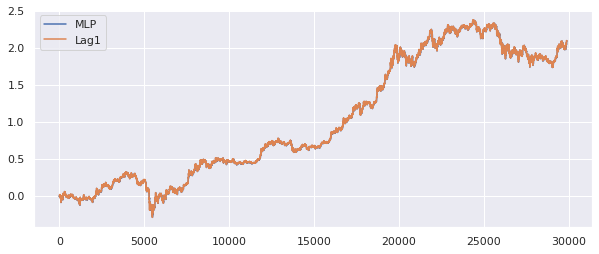

In [25]:
# Reimporting the data generated above.
# Useful if we want to try out multiple stacked datasets quickly, removing the need to re-run them 

save_num = ""
X_train = pd.read_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_X_train{}.csv".format(save_num)).values
X_test = pd.read_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_X_test{}.csv".format(save_num)).values
y_train = pd.read_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_y_train{}.csv".format(save_num)).values.reshape(-1,1)
y_test = pd.read_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_y_test{}.csv".format(save_num)).values.reshape(-1,1)


# Plotting the predictions from the models
for idx, name in enumerate(list(models.keys())):
  print(idx,name)
  plt.plot(np.cumsum(X_train[:,6+idx]), label = "{}".format(name))
plt.plot(np.cumsum(X_train[:,0]), label = "Lag1")
plt.legend()
plt.show()


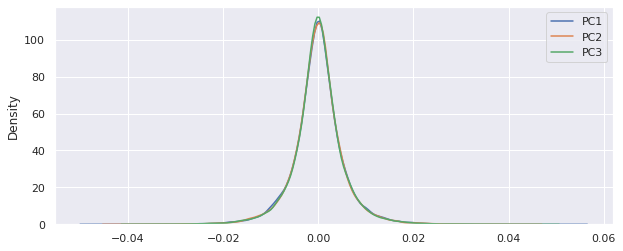

In [26]:
# PCA transformation is done here.
# PCA helps the models differentiate noise from meaningful signals
# More on the motivation behind using PCA here can be found in the report.pdf in this folder

from sklearn.decomposition import PCA
pca = PCA(whiten = False)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

for pc in range(0,3):
  sns.kdeplot((X_train[:,pc]), label = "PC{}".format(pc+1))
#plt.plot(np.cumsum(X_train[:,2]), label = "Lag1")
plt.legend()
plt.show()

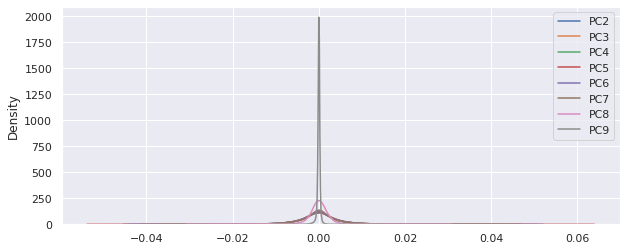

In [27]:
#for pc in range(0,X_train.shape[1]):
for pc in range(1,9):
  sns.kdeplot(X_train[:,pc], label = "PC{}".format(pc+1))
#plt.plot(np.cumsum(X_train[:,2]), label = "Lag1")
plt.legend()

In [40]:
fit_on = [0,1,2,3,4,5,6,7,8] # deciding which columns from the stacked dataset to train on. This is useful when investigating if some features are useful or just provide noise to the model

# Defining the xgboost Regressor
xgbr = xgboost.XGBRegressor(objective="reg:squarederror")

# Fitting the model on the data
xgbr_fit = xgbr.fit(X_train[:,fit_on],y_train)

# Predicting the data for train data
ypred_test = xgbr_fit.predict(X_test[:,fit_on])

# Predicting the data for test data
ypred_train = xgbr_fit.predict(X_train[:,fit_on])


### Training Data Analysis


In [41]:
# We print out useful evaluation metrics for the model

tu.print_metrics(y_train, ypred_train.reshape(-1,1))

RMSE: 0.0050639
MAE: 0.0034333
r2: 0.0613010
Merton: 0.9999978
              precision    recall  f1-score   support

           0       0.59      0.10      0.17     14685
           1       0.52      0.93      0.67     15195

    accuracy                           0.52     29880
   macro avg       0.55      0.52      0.42     29880
weighted avg       0.55      0.52      0.42     29880

[[ 1447 13238]
 [  998 14197]]


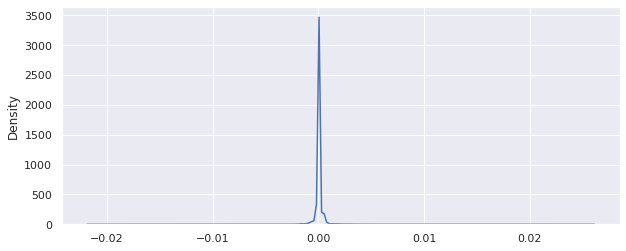

In [42]:
# Visulaising the distribution of the predictions
# Helps get an idea of how well the model is predicting 
# Ideally the model will produce a distribution similar to the underlying data
# We see a distribution with a very high peak and wide tails which resenmbes a normal distributuion in a range similar to the train data which is a positive sign

sns.kdeplot(ypred_train)
plt.show()

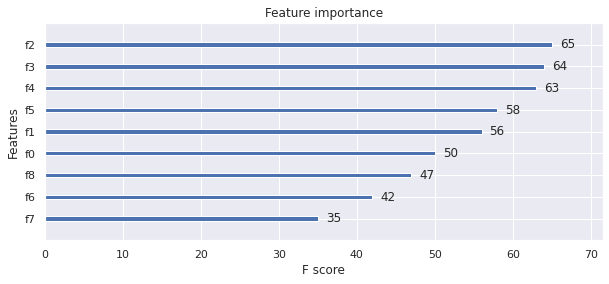

In [43]:
# Feature Importance is a useful way of investigating which features are most useful for predicting the y variable
# Since this data is actually all PCA features, we should see the features in order 0 - 8 as PCA operates on the first Principal component explains the most variance in the data
# What could be happening hre is the first and second principal components(which have the highest variance as defined by PCA) could be random noise and hence why they are not as useful in prediction

try:
  xgboost.plot_importance(xgbr_fit)
except:
  pass

In [ ]:
tu.plot_pie(y_train.ravel())

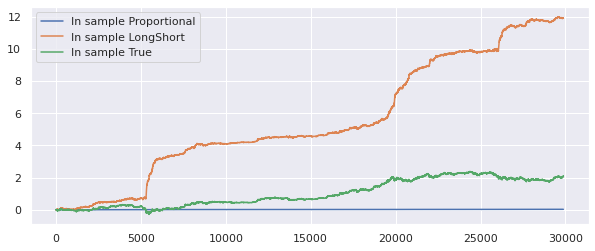

In [38]:
# Visulaizing how a long short strategy would have performed based on the model predictions in the training phase

tu.plot_strats(y_train, ypred_train.reshape(-1,1))

### Test Data Analysis

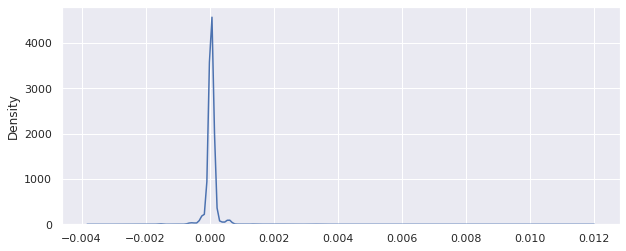

In [45]:
sns.kdeplot(ypred_test)

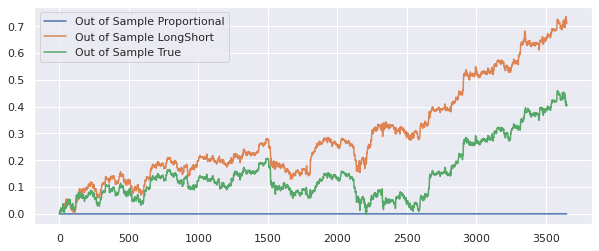

In [46]:
# Visulaizing how a long short strategy would have performed based on the model predictions in the test phase
# The model outperforms the underlying asset in this timeframe of 3500 30 minute periods (72 days and 23 hours)


tu.plot_strats(y_test, ypred_test.reshape(-1,1), name = "Out of Sample")

In [48]:
# The model shows good precision which is essential to a profitable long short strategy
tu.print_metrics(y_test, ypred_test.reshape(-1,1))

RMSE: 0.0045501
MAE: 0.0032341
r2: -0.0007319
Merton: 0.9999999
              precision    recall  f1-score   support

           0       0.52      0.06      0.11      1755
           1       0.52      0.95      0.67      1898

    accuracy                           0.52      3653
   macro avg       0.52      0.50      0.39      3653
weighted avg       0.52      0.52      0.40      3653

[[ 105 1650]
 [  96 1802]]
